In [1]:
import os
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt

# some SBML model
modelfile = 'https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL6615119181/2/BIOMD0000000010_url.xml'

r = te.loadSBMLModel(modelfile)
r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))

bin_model = 'model.b'
r.saveState(bin_model)

parameter_values = r.getGlobalParameterValues()

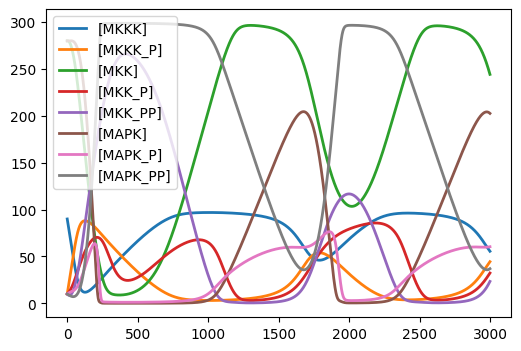

In [2]:
new_parameter_values = parameter_values*np.random.uniform(0, 1, len(parameter_values))
r.model.setGlobalParameterValues(parameter_values)

result = r.simulate(0, 3000, 5000)
r.reset()
r.plot(result)

In [15]:
class SBMLGlobalFit:

    def __init__(self, model, data, parameters, settings):
        self.model = model
        self.data = data
        self.parameters = parameters
        self.settings = settings
        self.upperb = [i*10 for i in parameters]
        self.lowerb = [i/10 for i in parameters]
        self.R = {}

    def fitness(self, x):
        import time
        pid = os.getpid()
        if not pid in self.R.keys():
            r = te.roadrunner.ExtendedRoadRunner()
            r.loadStateS(self.model)
            self.R[pid] = r
        r = self.R[pid]
        # r = te.loadSBMLModel(self.model)
        # r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))
        # r = te.roadrunner.ExtendedRoadRunner()
        # r.loadState('model.b')
        r.model.setGlobalParameterValues(x)
        
        try:
            results = r.simulate(0, 3000, 5000)[:,1:].__array__()
        except:
            results = self.data*0
        return self._residual(results,self.data)

    # def _residual(self,results,data,points):
    #     md = (np.nanmax(data,1,keepdims=True)-np.nanmin(data,1,keepdims=True))/2
    #     mr = (np.nanmax(results,1,keepdims=True)-np.nanmin(results,1,keepdims=True))/2
    #     denom = np.ones(data.shape)
    #     return [np.nansum(((data-results)/(points*(md**2+mr**2)**0.5*denom))**2)]
    def _residual(self,results,data):
        return [np.nansum(np.abs(data-results))]

    def get_bounds(self):
        return (self.lowerb, self.upperb)
    
    def get_name(self):
        return 'Global Fitting of Multiple SBML Models'

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x),x)


In [16]:
udi = pg.ipyparallel_island()
udi.init_view(client_kwargs={'profile':'cheme-ecfers'})

udbfe = pg.ipyparallel_bfe()
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'})

a = pg.pso_gen(gen=10)
a.set_bfe(pg.bfe(udbfe))
algo = pg.algorithm(a)
algo.set_verbosity(1)

prob = pg.problem(SBMLGlobalFit(model = r.saveStateS(), data = result[:,1:].__array__(), parameters=parameter_values, settings=None))
# prob = pg.problem(pg.rosenbrock(dim=10))

# my_island = pg.island(udi = udi, algo = algo, prob = prob, size =10, b = pg.bfe(udbfe), r_pol = pg.fair_replace(0.1), s_pol = pg.select_best(0.1))
archi = pg.archipelago(n=3,t=pg.ring(), algo=algo, prob=prob, pop_size=100, udi = udi, b = udbfe, r_pol = pg.fair_replace(0.1), s_pol = pg.select_best(0.1))

In [7]:
res =  []
for i in range(1):
    archi.evolve()
    archi.wait_check()
    res.append(np.array([a.get_algorithm().extract(pg.pso_gen).get_log()for a in archi]))
results = np.concatenate(res,axis=1)

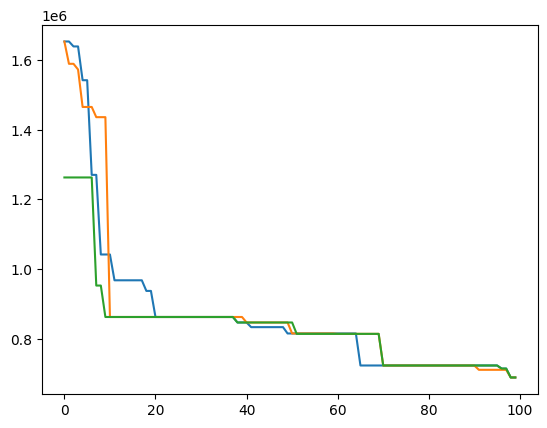

In [32]:
plt.plot(results[:,:,2].T)

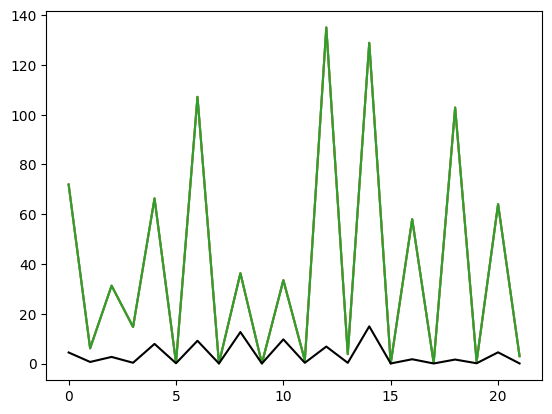

In [33]:
plt.plot(np.array(archi.get_champions_x()).T)
plt.plot(new_parameter_values,'k')

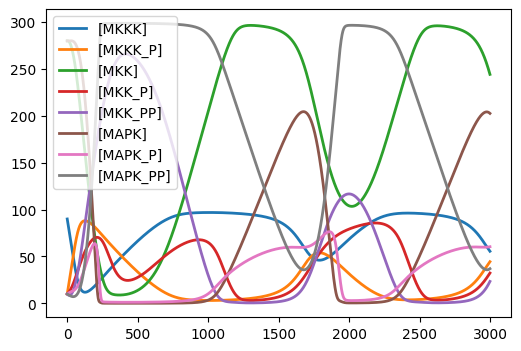

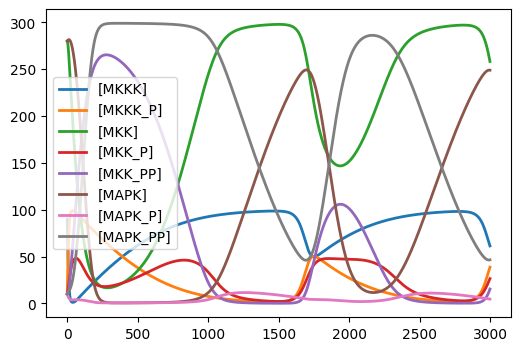

In [34]:
r.plot(result)

r.model.setGlobalParameterValues(archi.get_champions_x()[2])

result2 = r.simulate(0, 3000, 5000)
r.reset()
r.plot(result2)

In [214]:
r.getNumReactions()
r.getNumberOfIndependentSpecies()
r.getNumberOfDependentSpecies()

10

In [10]:
udi._view.apply_sync(lambda x: r.loadState('/gscratch/cheme/dalba/repos/ECFERS/model.b'),1)

['setup.py',
 '.config',
 'LICENSE',
 'model.b',
 '.gitattributes',
 'environment.yml',
 'pygmo_test.ipynb',
 '.devcontainer',
 'README.md',
 '.gitignore',
 '.ipython',
 '.git',
 'prototype.ipynb',
 '.cache',
 'src']